#### Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

#### Input the stock symbols

In [2]:
from datetime import datetime
stock = ['INFY','TCS','WIT']
start = datetime(2018,1,1)
end = datetime(2019,1,1)

#### A function to get the adjusted closing prices

In [3]:
def get_data(stock, start, end):
    data = web.DataReader(stock, data_source='yahoo', start=start, end=end)['Adj Close']
    return data

In [4]:
stock_data = get_data(stock, start, end)

In [88]:
stock_data.head()

Symbols,INFY,TCS,WIT
Date,,,
2018-01-02,7.708489,5.08,5.678730
2018-01-03,7.642240,4.85,5.638949
2018-01-04,7.594919,4.96,5.619059
2018-01-05,7.736881,4.85,5.529551
2018-01-08,7.798397,4.88,5.638949


#### Calculate and plot the daily returns of the individual stocks

In [29]:
returns_data = stock_data.pct_change().rolling(20).mean() ##moving average is used to smoothen the data

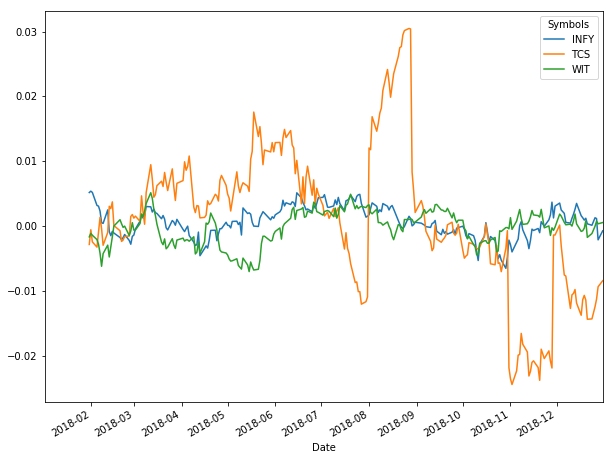

In [28]:
returns_data.plot(figsize=(10,8))

#### Suppose we want to make a portfolio of these 3 stocks then we can optimize it based on the following conditions
#### i)Maximum Sharpe Ratio ( Reward/Risk ratio)
#### ii)A portfolio with a minimum risk with a desired level of expected return
#### iii)Maximum return at a desired level of risk

In [16]:
def portfolio_returns(df,weights):
    returns = df.pct_change()
    returns_mean = 252 * returns.mean()
    PR = sum(returns_mean * weights)
    return PR
  

#### Above function calculates the expected return for the portfolio

#### portfolio_std calculates the risk associated

In [30]:
def portfolio_std(df, weights):
    corr_matrix = df.pct_change().corr()
    std_matrix = np.array(df.pct_change().std()).reshape(1,len(weights)) * weights
    return np.sqrt(252) * np.sqrt(std_matrix.dot(corr_matrix).dot(std_matrix.T))[0][0]

#### Monte Carlo simulation method is used to optimize our portfolio. 
#### Randoms weights are assigned to the stocks and portfolio returns and risk is evaluated for each set of values.
#### We need to make sure that the weights assigned add up to 1. Later the weights are changed and the same process is repeated for 1000 iterations(in our case). 
#### To achieve higher accuracy, the number of iterations should be increased but it also increases the computation time
#### This function takes the closing price dataframe, number of iterations, stock list and criteria as the input 

In [41]:
def portfolio_optmization(df, num_iter, stock, criteria):
    simulation_res = np.zeros((num_iter, 3+len(stock)))
    for i in range(num_iter):
        weights = np.array(np.random.random(len(stock)))
        weights /= np.sum(weights)
        
        p_ret = portfolio_returns(df, weights)
        p_std = portfolio_std(df, weights)
        sharpe = p_ret/p_std
        
        for j in range(len(stock)):
            simulation_res[i,j] = weights[j]
        
        simulation_res[i,len(stock)] = p_ret
        simulation_res[i,len(stock)+1] = p_std
        simulation_res[i,len(stock)+2] = sharpe
        
        
    col_names = stock.copy()
    col_names.extend(['ret','std','sharpe'])    
    sim_frame = pd.DataFrame(simulation_res, columns=col_names)
        
    if criteria == 1:
        max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]
        return 'Max Sharpe Ratio', max_sharpe
    if criteria == 2:
        min_std = sim_frame.iloc[sim_frame['std'].idxmin()]
        return 'Min Risk', min_std
    if criteria == 3:
        max_ret = sim_frame.iloc[sim_frame['ret'].idxmax()]
        return 'Max return', max_ret

#### For Max Sharpe ratio input criteria = 1
#### For Min Risk input criteria = 2
#### For Max Return input criteria = 3

In [42]:
sim = portfolio_optmization(stock_data,1000, stock,1)

In [43]:
sim

('Max Sharpe Ratio', INFY      0.884743
 TCS       0.078556
 WIT       0.036701
 ret       0.212970
 std       0.225269
 sharpe    0.945404
 Name: 205, dtype: float64)

In [37]:
sim2 = portfolio_optmization(stock_data,1000, stock,2)

In [38]:
sim2

('Min Risk', INFY      0.512047
 TCS       0.042850
 WIT       0.445103
 ret       0.090621
 std       0.198076
 sharpe    0.457507
 Name: 748, dtype: float64)

In [39]:
sim3 = portfolio_optmization(stock_data,1000, stock,3)

In [40]:
sim3

('Max return', INFY      0.130039
 TCS       0.864495
 WIT       0.005466
 ret       0.245514
 std       0.677444
 sharpe    0.362413
 Name: 235, dtype: float64)

#### Calculate alpha and beta for the portfolio from the CAPM(Capital Asset Pricing Model)

#### NIFTY IT index is chosen as the benchmark to evaluate the beta

In [113]:
market_index = pd.read_csv('^CNXIT.csv')

In [114]:
market_index.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,11587.849609,11655.500000,11558.450195,11602.349609,11602.349609,0
1,2018-01-03,11617.349609,11693.349609,11573.250000,11586.700195,11586.700195,0
2,2018-01-04,11599.049805,11607.750000,11510.400391,11590.799805,11590.799805,0
3,2018-01-05,11575.450195,11691.450195,11541.799805,11633.549805,11633.549805,0
4,2018-01-08,11674.349609,11793.849609,11661.500000,11776.849609,11776.849609,0


In [115]:
market_index['returns'] = market_index['Adj Close'].pct_change()

In [116]:
market_index.head()

,Date,Open,High,Low,Close,Adj Close,Volume,returns
0,2018-01-02,11587.849609,11655.500000,11558.450195,11602.349609,11602.349609,0,NaN
1,2018-01-03,11617.349609,11693.349609,11573.250000,11586.700195,11586.700195,0,-0.001349
2,2018-01-04,11599.049805,11607.750000,11510.400391,11590.799805,11590.799805,0,0.000354
3,2018-01-05,11575.450195,11691.450195,11541.799805,11633.549805,11633.549805,0,0.003688
4,2018-01-08,11674.349609,11793.849609,11661.500000,11776.849609,11776.849609,0,0.012318


In [117]:
stock_copy = stock_data.copy()

In [118]:
optimized_weights = []
for i in range(3):
    optimized_weights.append(sim[1][i])

In [119]:
optimized_weights

[0.8847430069424077, 0.07855618181336137, 0.036700811244231066]

In [120]:
stock_returns = stock_copy.pct_change() * optimized_weights

In [121]:
stock_returns['returns'] = stock_returns.sum(axis = 1)

In [130]:
market_index.set_index(market_index['Date'], inplace = True)

In [134]:
market_index.drop('Date', axis = 1, inplace=True)

#### Beta = Covariance(Ri,Rm)/Variance(Rm)

In [144]:
beta = (market_index['returns'].cov(stock_returns['returns']))/np.var(market_index['returns'])

In [145]:
beta

0.4638836447931673

#### Assume a risk free rate of 3%
#### Alpha = R(i) - (R(f) + B x (R(m) - R(f))) 
R(i) = the realized return of the portfolio or investment

R(m) = the realized return of the appropriate market index

R(f) = the risk-free rate of return for the time period

B = the beta of the portfolio of investment with respect to the chosen market index

In [149]:
Rm = market_index['returns'].mean() * 252
Rf = 0.03
Ri = sim[1][3]

In [150]:
Alpha = Ri - (Rf + beta * (Rm - Ri))

In [151]:
Alpha

0.1682220340202269